In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from neuralbridge.run_scripts.read_config import read_config
from neuralbridge.stochastic_processes.examples import (
    LandmarkLagrangianProcess, 
    LandmarkLagrangianAuxProcess
)
from neuralbridge.solvers.sde import WienerProcess, Euler
from neuralbridge.stochastic_processes.conds import GuidedBridgeProcess
from neuralbridge.models import neurb, pCN, scorematching
from neuralbridge.utils.plotting import plot_landmark_sample_path

INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)


In [3]:
config = read_config("../configs/landmark_ellipse.yaml")
print(config)
u = jnp.array(config.sde.u)
v = jnp.array(config.sde.v)
u_closed = jnp.concatenate([u, u[:2]]).reshape(-1, 2)
v_closed = jnp.concatenate([v, v[:2]]).reshape(-1, 2)

{'sde': {'n_landmarks': 32, 'T': 1.0, 'dt': 0.01, 'dim': None, 'params_X': {'k_alpha': 0.3, 'k_sigma': 0.5, 'n_landmarks': 32, 'm_landmarks': 2}, 'params_X_tilde': {'k_alpha': 0.3, 'k_sigma': 0.5, 'n_landmarks': 32, 'm_landmarks': 2}, 'u': [0.0, 0.5, 0.19509032368659973, 0.49039262533187866, 0.3826834559440613, 0.4619397521018982, 0.5555702447891235, 0.41573479771614075, 0.7071067690849304, 0.3535533845424652, 0.8314696550369263, 0.2777850925922394, 0.9238795042037964, 0.19134171307086945, 0.9807853102684021, 0.09754511713981628, 1.0, -2.1855694143368964e-08, 0.9807852506637573, -0.09754516184329987, 0.9238795042037964, -0.19134175777435303, 0.8314695358276367, -0.27778518199920654, 0.7071067690849304, -0.3535533845424652, 0.5555701851844788, -0.41573482751846313, 0.38268327713012695, -0.46193981170654297, 0.19509030878543854, -0.49039265513420105, -8.742277657347586e-08, -0.5, -0.19509048759937286, -0.49039262533187866, -0.3826834559440613, -0.4619397521018982, -0.5555703043937683, -0

unconditional process plotting

In [4]:
W = WienerProcess(
    T=config.sde.T,
    dt=config.sde.dt,
    shape=u.shape
)

X = LandmarkLagrangianProcess(
    params=config.sde.params_X,
    T=config.sde.T
)

X_solver = Euler(X, W)
X_path = X_solver.solve(x0=u, batch_size=4)

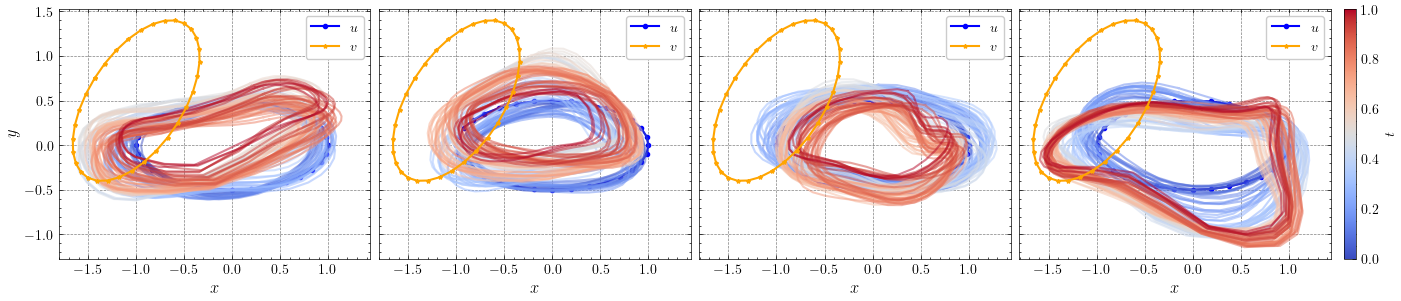

In [8]:
fig, axes = plt.subplots(1, 4, figsize=(14, 3), sharey=True, sharex=True, layout="constrained")
axes[0].set_ylabel(r'$y$', fontsize=12)

for i, ax in enumerate(axes):
    ax.plot(*u_closed.T, '-o', color="blue", alpha=1.0, linewidth=1.5, markersize=3, label=r'$u$')
    ax, mappable = plot_landmark_sample_path(
        X_path[i],
        ax=ax,
        m_landmarks=2,
        cmap="coolwarm",
        show_intermediate_shapes=True,
        show_intermediate_trajectories=False,
        markersize=1,
        alpha=0.5,
        show_every=1,
        linewidth=1.5,
        show_colorbar=False
    )
    ax.set_xlabel(r'$x$', fontsize=12)
    ax.plot(*v_closed.T, '-*', color="orange", alpha=1.0, linewidth=1.5, markersize=3, label=r'$v$')
    ax.legend()

fig.colorbar(mappable, ax=axes.ravel().tolist(), label=r'$t$', pad=0.01)
fig.savefig("../doc/Neural Guided Diffusion Bridges/arxiv/images/landmark/ellipse_unconditional.pdf", dpi=300, bbox_inches="tight")

Neural bridge

In [6]:
X_tilde = LandmarkLagrangianAuxProcess(
    params=config.sde.params_X_tilde,
    T=config.sde.T
)
X_tilde.init_g(v=v)
X_circ = GuidedBridgeProcess(
    X=X,
    X_tilde=X_tilde,
    u=u,
    v=v,
    eps=config.sde.eps,
    ts=jnp.arange(0, config.sde.T + config.sde.dt, config.sde.dt)
)
X_circ_solver = Euler(X_circ, W)
X_circ_path = X_circ_solver.solve(x0=u, rng_key=jax.random.PRNGKey(42), batch_size=4)
X_diamond = neurb.NeuralBridge(
    X_circ=X_circ,
    config=config
)
X_diamond.initialize_solver(W)
_ = X_diamond.train(mode="pretrained", load_relative_dir="../assets/ckpts/neurb")
X_diamond_path = X_diamond.solve(x0=u, rng_key=jax.random.PRNGKey(42), batch_size=4)

/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1136: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(
INFO:root:Checkpoint loaded from /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neurb/landmark_ellipse_32
INFO:root:Loading pretrained model from the last epoch


Pre-conditioned Crank-Nicolson

In [18]:
config = {
    "seed": 42,
    "rho": 0.9,
    "batch_size": 16,
    "n_iters": 10000
}
pCN_model = pCN.PreconditionedCrankNicolson(
    X_circ=X_circ,
    config=config
)
pCN_model.initialize_solver(W)
_, pCN_result = pCN_model.run()
X_star_pCN_path = pCN_result.path

Running pCN: 100%|██████████| 10000/10000 [02:29<00:00, 66.87it/s]
INFO:root:Batch average acceptance rate: 15.14%


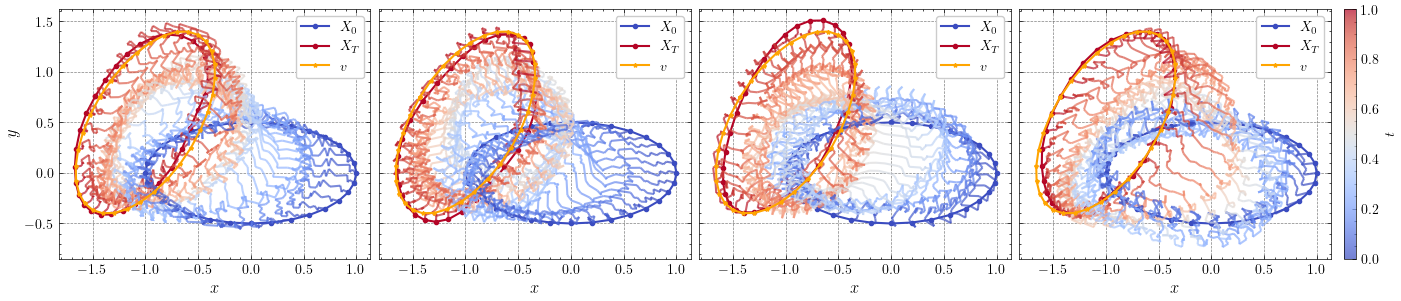

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(14, 3), sharey=True, sharex=True, layout="constrained")
axes[0].set_ylabel(r'$y$', fontsize=12)

for i, ax in enumerate(axes):
    _, mappable = plot_landmark_sample_path(
        X_diamond_path[i],
        ax=ax,
        m_landmarks=2,
        cmap="coolwarm",
        show_intermediate_trajectories=True,
        show_intermediate_shapes=False,
        markersize=3,
        alpha=0.7,
        show_every=1,
        linewidth=1.5,
        show_colorbar=False
    )
    ax.set_xlabel(r'$x$', fontsize=12)
    ax.plot(*v_closed.T, '-*', color="orange", alpha=1.0, linewidth=1.5, markersize=3, label=r'$v$')
    ax.legend()

fig.colorbar(mappable, ax=axes.ravel().tolist(), label=r'$t$', pad=0.01)
fig.savefig("../doc/Neural Guided Diffusion Bridges/arxiv/images/landmark/neurb_ellipse_32.pdf", dpi=300, bbox_inches="tight")

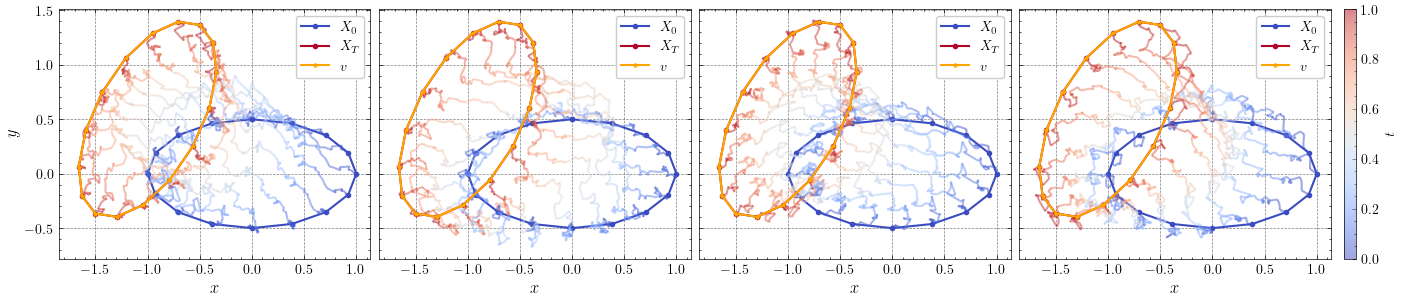

In [37]:
fig, axes = plt.subplots(1, 4, figsize=(14, 3), sharey=True, sharex=True, layout="constrained")
axes[0].set_ylabel(r'$y$', fontsize=12)

for i, ax in enumerate(axes):
    _, mappable = plot_landmark_sample_path(
        X_star_pCN_path[i],
        ax=ax,
        m_landmarks=2,
        cmap="coolwarm",
        show_intermediate_trajectories=True,
        show_intermediate_shapes=False,
        markersize=3,
        alpha=0.5,
        show_every=1,
        linewidth=1.5,
        show_colorbar=False
    )
    ax.set_xlabel(r'$x$', fontsize=12)
    ax.plot(*v_closed.T, '-*', color="orange", alpha=1.0, linewidth=1.5, markersize=3, label=r'$v$')
    ax.legend()

fig.colorbar(mappable, ax=axes.ravel().tolist(), label=r'$t$', pad=0.01)